## Read files into a pandas DataFrame

In [1]:
PATH="/home/kirana/Documents/phd"
DATAPATH="/home/kirana/Documents/phd/data/aclImdb"

In [2]:
import fastai
from fastai.text import *
from fastai import *

In [3]:
ls {DATAPATH}

imdbEr.txt  imdb.vocab  README  test/  train/


In [4]:
ls {DATAPATH}/train

labeledBow.feat  pos/    unsupBow.feat  urls_pos.txt
neg/             unsup/  urls_neg.txt   urls_unsup.txt


In [5]:
ls {DATAPATH}/test

labeledBow.feat  neg/  pos/  urls_neg.txt  urls_pos.txt


In [6]:
subpaths=['train/pos','train/neg','train/unsup','test/pos','test/neg']

In [7]:
def read_files_from_folder(DATAPATH,subpaths):
    dflist=[]
    for subpath in subpaths:
        path=f'{DATAPATH}/{subpath}'
        files=os.listdir(path)
        files=[f for f in files if f.endswith('.txt')]
        dstype=str.split(subpath,'/')[0]
        label=str.split(subpath,'/')[1]
        text=[open(f'{DATAPATH}/{subpath}/{f}','r').readlines()[0] for f in files]
        df=pd.DataFrame({'text':text})
        df['label']=label
        df['dstype']=dstype
        dflist.append(df) 
    df=pd.concat(dflist)
    return df

In [8]:
df=read_files_from_folder(DATAPATH,subpaths)

In [9]:
df.head()

,text,label,dstype
0,and possibly closest to the Dickens story line...,pos,train
1,A small pleasure in life is walking down the o...,pos,train
2,Have just seen the Australian premiere of Show...,pos,train
3,Thankfully saw this on a plane to Singapore re...,pos,train
4,The movie itself was ok for the kids. But I go...,pos,train


In [10]:
import pickle

In [11]:
pd.crosstab(df['dstype'],df['label'])

label,neg,pos,unsup
dstype,,,
test,12500,12500,0
train,12500,12500,50000


In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
myle=LabelEncoder()

In [14]:
df['label']=myle.fit_transform(df['label'])

In [15]:
df['label'].value_counts()

2    50000
1    25000
0    25000
Name: label, dtype: int64

## Cross-Validation

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
df_test=df.loc[df['dstype']=='test']
df_train=df.loc[df['dstype']=='train']

In [18]:
df_train,df_valid=train_test_split(df_train,train_size=0.9,test_size=0.1,random_state=11,shuffle=True)

In [19]:
df.shape,df_train.shape,df_valid.shape,df_test.shape

((100000, 3), (67500, 3), (7500, 3), (25000, 3))

In [20]:
df.head()

,text,label,dstype
0,and possibly closest to the Dickens story line...,1,train
1,A small pleasure in life is walking down the o...,1,train
2,Have just seen the Australian premiere of Show...,1,train
3,Thankfully saw this on a plane to Singapore re...,1,train
4,The movie itself was ok for the kids. But I go...,1,train


In [21]:
df_train=df_train.loc[:,['label','text']]
df_valid=df_valid.loc[:,['label','text']]
df_test=df_test.loc[:,['label','text']]

In [22]:
df_train.to_csv(f'{PATH}/inter/df_train.csv',index=False)
df_valid.to_csv(f'{PATH}/inter/df_valid.csv',index=False)
df_test.to_csv(f'{PATH}/inter/df_test.csv',index=False)


## Tokenize and Numericalize

In [23]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:, range(n_lbls)].values.astype(np.int64)

    texts = f'\n{BOS} {FLD} 1 ' + df.iloc[:,n_lbls].astype(str)
    for i in range(n_lbls + 1, len(df.columns)):
        texts += f' {FLD} {i - n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tokenizer = Tokenizer(n_cpus=10)
    tokop=tokenizer.process_all(texts)
    return tokop, list(labels)


def get_all(df, n_lbls):
    tok, labels = [], []
    #import pdb
    #pdb.set_trace()
    for i, txt in enumerate(df):
        tok_, labels_ = get_texts(txt, n_lbls)
        tok += tok_
        labels += labels_
    return tok, labels

In [24]:
chunksize=24000
chunk_train=pd.read_csv(f'{PATH}/inter/df_train.csv',chunksize=chunksize)
chunk_valid=pd.read_csv(f'{PATH}/inter/df_valid.csv',chunksize=chunksize)
chunk_test=pd.read_csv(f'{PATH}/inter/df_test.csv',chunksize=chunksize)



In [25]:
train_tokens, train_labels = get_all(chunk_train, 1)
valid_tokens, valid_labels = get_all(chunk_valid, 1)
test_tokens, test_labels = get_all(chunk_test, 1)

In [26]:
df_train['words']=train_tokens
df_valid['words']=valid_tokens
df_test['words']=test_tokens

In [27]:
freq = Counter(p for o in train_tokens for p in o)
freq.most_common(25)

[('xxmaj', 1704081),
 ('the', 912744),
 ('.', 746692),
 (',', 745869),
 ('and', 444260),
 ('a', 440858),
 ('of', 396150),
 ('to', 366366),
 ('is', 297479),
 ('it', 258089),
 ('in', 254252),
 ('i', 231608),
 ('this', 203711),
 ('that', 197861),
 ('"', 178689),
 ("'s", 167922),
 ('-', 143037),
 ('\n \n ', 137426),
 ('was', 136078),
 ('as', 125813),
 ('xxup', 121824),
 ('with', 120233),
 ('for', 120232),
 ('movie', 118739),
 ('but', 114132)]

In [28]:
max_vocab = 60000
min_freq = 2

itos = [o for o, c in freq.most_common(max_vocab) if c > min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [29]:
stoi = collections.defaultdict(lambda: 0, { v: k for k, v in enumerate(itos) })
len(itos)

59972

In [30]:
trn_lm = np.array([ [stoi[o] for o in p] for p in train_tokens ])
val_lm = np.array([ [stoi[o] for o in p] for p in valid_tokens ])
test_lm = np.array([ [stoi[o] for o in p] for p in test_tokens ])

In [31]:
df_train['tokens']=trn_lm
df_valid['tokens']=val_lm
df_test['tokens']=test_lm

In [34]:
pickle.dump([df_train,df_valid,df_test,itos, train_tokens, valid_tokens, test_tokens, trn_lm, val_lm, test_lm],open(f'{PATH}/inter/dfs_tokens_fastai.pkl','wb'))

In [35]:
[df_train,df_valid,df_test,itos, train_tokens, valid_tokens, test_tokens, trn_lm, val_lm, test_lm]=pickle.load(open(f'{PATH}/inter/dfs_tokens_fastai.pkl','rb'))

## Dataset

In [36]:
bs=20 # 52 - Jeremey, 20 - default

In [37]:
bptt= 35 #70 - Jeremey, 35 - default

In [38]:
def create_data_lm(tokens,bs):
    import itertools
    # Collapse into a single large array
    tokens=np.asarray(list (itertools.chain(*tokens)))
    # How many batches
    n_batch=len(tokens)//bs
    # Truncate to exclude the ones at the end
    tokens=tokens[:bs*n_batch]
    # Reshape
    tokens=tokens.reshape(bs,-1)
    return tokens

In [39]:
train_tokens=create_data_lm(df_train['tokens'],bs)
valid_tokens=create_data_lm(df_valid['tokens'],bs)
test_tokens=create_data_lm(df_test['tokens'],bs)
train_tokens.shape, valid_tokens.shape, test_tokens.shape

((20, 1031291), (20, 114129), (20, 372474))

In [40]:
def get_batch(source, i):
    seq_len = min(args.bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

In [41]:
n_batch=train_tokens.shape[1]
for i in range(0,n_batch,bptt):
    seq_len=min(bptt,n_batch-1-i)
    x=train_tokens[:,i:i+seq_len]
    y=train_tokens[:,i+1:i+1+seq_len]
    print (x.shape, y.shape)
    break

(20, 35) (20, 35)


In [42]:
x.shape,y.shape

((20, 35), (20, 35))

In [43]:
x,y

(array([[   41,    42,    43,    40, ...,  1033,     7,   189,    21],
        [  103,   278,  3442, 43417, ...,     0,     2,     0,     6],
        [    2,  1065,   732,   227, ...,    11,    73,    38,   576],
        [    0,    29,    10,  2414, ...,    11,   817,  9572,     6],
        ...,
        [ 2626,  2008,   849,     4, ...,     6,     3, 21421,    59],
        [    5,    35,    10,    59, ...,   182,   200,    61,     5],
        [ 3863,  3557,   193,    18, ...,    23,     3,  1504,    28],
        [   66,     2,     9,   894, ...,   399,   111,     9,    58]]),
 array([[   42,    43,    40,    13, ...,     7,   189,    21,    13],
        [  278,  3442, 43417,     5, ...,     2,     0,     6,     2],
        [ 1065,   732,   227,   166, ...,    73,    38,   576,  1104],
        [   29,    10,  2414,     6, ...,   817,  9572,     6,  1800],
        ...,
        [ 2008,   849,     4,     2, ...,     3, 21421,    59,     3],
        [   35,    10,    59,     9, ...,   200, 

In [44]:
x.shape,y.shape

((20, 35), (20, 35))

In [45]:
train_tokens.shape

(20, 1031291)

## pre-trained AWD-LSTM

In [46]:
PATH_AWD_LSTM='/home/kirana/Documents/phd/data/pre-trained/awd_lstm/'

In [47]:
ls {PATH_AWD_LSTM}

bwd_wt103_enc.h5  fwd_wt103_enc.h5  itos_wt103.pkl  wt103_60002/
bwd_wt103.h5      fwd_wt103.h5      wt103_238642/   wt103_tiny.tgz


In [48]:
wgts = torch.load(f'{PATH_AWD_LSTM}/fwd_wt103.h5', map_location=lambda storage, loc: storage)

In [49]:
wgts

OrderedDict([('0.encoder.weight',
              tensor([[-1.2274e-01,  2.7886e-01, -3.8850e-01,  ..., -1.0404e-01,
                        1.9580e-02,  1.8548e-01],
                      [ 1.4854e-05, -2.3424e-05,  1.9693e-05,  ...,  2.1349e-05,
                        2.1776e-05, -1.2394e-05],
                      [ 1.8070e-01,  1.5874e+00, -1.1738e-01,  ..., -4.5935e-02,
                       -8.1352e-02,  1.8054e-01],
                      ...,
                      [-1.8595e-03, -6.8529e-03,  1.6999e-03,  ...,  1.7039e-03,
                        4.1632e-03, -1.3171e-03],
                      [-2.3120e-03, -6.9001e-03,  1.8772e-03,  ...,  5.0309e-04,
                        4.6596e-03, -2.5850e-03],
                      [-2.2463e-03, -9.1512e-03,  1.3927e-03,  ...,  1.2296e-03,
                        5.8085e-03, -1.8940e-03]])),
             ('0.encoder_with_dropout.embed.weight',
              tensor([[-1.2274e-01,  2.7886e-01, -3.8850e-01,  ..., -1.0404e-01,
                

In [50]:
wgts = torch.load(f'{PATH_AWD_LSTM}/fwd_wt103_enc.h5', map_location=lambda storage, loc: storage)

In [51]:
wgts

OrderedDict([('encoder.weight',
              tensor([[-1.2274e-01,  2.7886e-01, -3.8850e-01,  ..., -1.0404e-01,
                        1.9580e-02,  1.8548e-01],
                      [ 1.4854e-05, -2.3424e-05,  1.9693e-05,  ...,  2.1349e-05,
                        2.1776e-05, -1.2394e-05],
                      [ 1.8070e-01,  1.5874e+00, -1.1738e-01,  ..., -4.5935e-02,
                       -8.1352e-02,  1.8054e-01],
                      ...,
                      [-1.8595e-03, -6.8529e-03,  1.6999e-03,  ...,  1.7039e-03,
                        4.1632e-03, -1.3171e-03],
                      [-2.3120e-03, -6.9001e-03,  1.8772e-03,  ...,  5.0309e-04,
                        4.6596e-03, -2.5850e-03],
                      [-2.2463e-03, -9.1512e-03,  1.3927e-03,  ...,  1.2296e-03,
                        5.8085e-03, -1.8940e-03]])),
             ('encoder_with_dropout.embed.weight',
              tensor([[-1.2274e-01,  2.7886e-01, -3.8850e-01,  ..., -1.0404e-01,
                    

In [52]:
itos2=pickle.load(open(f'{PATH_AWD_LSTM}/itos_wt103.pkl','rb'))
stoi2 = collections.defaultdict(lambda: -1, { v: k for k, v in enumerate(itos2) })

In [53]:
wgts['encoder.weight'].shape

torch.Size([238462, 400])

In [54]:
enc_wgts = wgts['encoder.weight'].numpy() # converts np.ndarray from torch.FloatTensor.output shape: (238462, 400)
row_m = enc_wgts.mean(0) # returns the average of the array elements along axis 0. output shape: (400,)

In [55]:
enc_wgts.shape, len(itos)

((238462, 400), 59972)

In [56]:
n_emb=enc_wgts.shape[1]

In [57]:
new_w = np.zeros((len(itos),n_emb), dtype=np.float32) # shape: (60002, 400)

for i, w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r >= 0 else row_m

In [58]:
len(set(itos).difference(set(itos2)))

8910

## Model Architecture

In [59]:
from torch import nn
import torch
from adaptive import *
from torch.autograd import Variable

In [60]:
n_inp=len(itos)
n_emb=400 #650
n_hidden=400 #650
n_layers=2
dropout=0.5
wd=1e-7

In [72]:
class language_model (nn.Module):
    def __init__(self,n_inp,n_emb,n_hidden,n_layers,bidirectional,bs,device,dropout_e=0.05,dropout=0.5,\
                 dropout_o=0.5,pretrain_mtx=None,adaptive_log_softmax=True,tie_weights=True):
        super().__init__()
        self.n_inp,self.n_emb,self.n_hidden,self.n_layers,self.bidirectional,self.bs,self.device,self.pretrain_mtx=\
                            n_inp,n_emb,n_hidden,n_layers,bidirectional,bs,device,pretrain_mtx
        self.adaptive_log_softmax,self.tie_weights=adaptive_log_softmax,tie_weights
        self.dropout_e,self.dropout,self.dropout_o=dropout_e,dropout,dropout_o
        self.gen_hidden()
        self.create_architecture()
        if pretrain_mtx is not None:
            print ("initializing")
            self.initialize_glove()
            
        if self.adaptive_log_softmax is False:
            self.criterion=nn.CrossEntropyLoss()
        
    def create_architecture(self):
        # Dropout layer
        self.dropout_enc=nn.Dropout(self.dropout_e)
        # Embedding Layer
        self.encoder=nn.Embedding(self.n_inp,self.n_emb)
        # LSTM Layer
        self.lstm=nn.LSTM(self.n_emb,self.n_hidden,self.n_layers,batch_first=True,dropout=self.dropout,\
                          bidirectional=False)
        self.dropout_op=nn.Dropout(self.dropout_o)
        
        if self.adaptive_log_softmax:
            # Adaptive Log Softmax Loss
            self.adaptive_softmax=AdaptiveLogSoftmaxWithLoss(self.n_hidden,
                                    self.n_inp,
                                    cutoffs=[round(self.n_inp/15),3*round(self.n_inp/15)],
                                    div_value=4,
                                    get_full_prob=True)
        else:
            self.decoder=nn.Linear(self.n_hidden,self.n_inp)
    
    def freeze_embedding(self):
        self.encoder.weight.requires_grad=False
        
    
    def unfreeze_embedding(self):
        self.encoder.weight.requires_grad=True
        
        
    def initialize_glove(self):
        self.encoder.weight.data=torch.Tensor(self.pretrain_mtx)
        self.decoder.weight=self.encoder.weight
    
    def gen_hidden(self):
        # Initialize hidden
        self.hidden=(Variable(torch.zeros(self.n_layers,self.bs,self.n_hidden,requires_grad=False).to(self.device)),
                     Variable(torch.zeros(self.n_layers,self.bs,self.n_hidden,requires_grad=False).to(self.device)))
    
        
    def forward(self,Xb,Yb):
        #import pdb
        #pdb.set_trace()
        embs=self.dropout_enc(self.encoder(Xb))
        if Xb.size(0) < self.bs:
            self.hidden=(self.hidden[0][:,:Xb.size(0),:].contiguous(),
            self.hidden[1][:,:Xb.size(0),:].contiguous())
        out,new_hidden=self.lstm(embs,self.hidden)
        out=self.dropout_op(out)
        out=out.reshape(out.size(0)*out.size(1),out.size(2))        # output is of shape n_batch * n_seq * n_hidden
        # Wrap the hidden state in a new tensor without the gradients
        self.hidden=(Variable(new_hidden[0].data,requires_grad=False).to(self.device),\
                     Variable(new_hidden[1].data,requires_grad=False).to(self.device))
        if self.adaptive_log_softmax:
            out=self.adaptive_softmax(out,Yb.view(-1))
            loss=out.loss
            preds=out.output_full
        else:
            loss=self.criterion(out.view(-1, self.model.n_inp),Yb)
            preds=self.decoder(out)
        return preds, loss  

In [62]:
def accuracy_multinomial(preds,actual):
    preds=preds.max(1)[1]
    correct=preds==actual
    return correct.float().sum()/len(correct)

In [63]:
device='cuda:0'
model=language_model(n_inp,n_emb,n_hidden,n_layers,False,bs,device,0.05,0.5,0.5,new_w,False,True)
model=model.to(device)

initializing


In [64]:
model.encoder.weight.data

tensor([[-1.2274e-01,  2.7886e-01, -3.8850e-01,  ..., -1.0404e-01,
          1.9580e-02,  1.8548e-01],
        [ 1.4854e-05, -2.3424e-05,  1.9693e-05,  ...,  2.1349e-05,
          2.1776e-05, -1.2394e-05],
        [-1.8296e-02, -1.3826e-01,  1.4381e-02,  ...,  4.8841e-03,
          5.7428e-02, -7.5990e-03],
        ...,
        [-1.8296e-02, -1.3826e-01,  1.4381e-02,  ...,  4.8841e-03,
          5.7428e-02, -7.5990e-03],
        [-1.8296e-02, -1.3826e-01,  1.4381e-02,  ...,  4.8841e-03,
          5.7428e-02, -7.5990e-03],
        [-1.8296e-02, -1.3826e-01,  1.4381e-02,  ...,  4.8841e-03,
          5.7428e-02, -7.5990e-03]], device='cuda:0')

## Learner

In [65]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
  
        
    
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
            
        preds,loss=self.model(Xb,Yb)
        
       
            
        
        with torch.no_grad():
            acc=self.metric_fn(preds,Yb.view(-1))
            acc=acc.item()
            del preds
        
        if mode_train:
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.25)
            if 1==0:
                for p in self.model.parameters():
                    p.data.add_(self.lr, p.grad.data)
        
        return myloss, acc
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        n_batch=iterator.shape[1]
        epoch_loss,epoch_acc,i=0,0,0
        self.model.gen_hidden()
        for k,i in enumerate(range(0,n_batch,self.bptt)):
            seq_len=min(bptt,n_batch-1-i)
            Xb=train_tokens[:,i:i+seq_len]
            Yb=train_tokens[:,i+1:i+1+seq_len]
            Xb=torch.LongTensor(Xb)
            Yb=torch.LongTensor(Yb)
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            
            epoch_loss+=loss
            epoch_acc+=acc
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  {epoch_acc/(k)}')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/k
        epoch_acc=epoch_acc/k
        
        if 1==0:
            lr /= 4.0
            # Freeze all the layers initially
            for param in resnet.parameters():
                param.requires_grad=False
            torch.save(resnet,'resnet')
            torch.save(resnet.state_dict(),'resnet_state_dict')
            resnet.load_state_dict(torch.load('resnet_state_dict'))
            for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr  
            
        return epoch_loss,epoch_acc
    
    def plot_lrs(self, n_roll=1):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')

    
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):
        for epoch in range(n_epochs):
            
            loss,acc=self.run_epoch(dltrain,True)
            print (f'Epoch:{epoch} Loss:{loss}')
            lossv,accv=self.run_epoch(dlvalid,mode_train=False)
            print (f'Epoch:{epoch} Loss:{loss} Accuracy:{acc} Loss:{lossv} Accuracy:{accv}')
        

In [66]:
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3,betas=(0.9,0.999), weight_decay=wd)
metric_fn=accuracy_multinomial

In [67]:
train_tokens.shape[1]/bptt

29465.457142857143

In [69]:
learner=Learner(model,optimizer,accuracy_multinomial,device,bptt,500,0.25)

In [70]:
n_batch=np.int(np.ceil(valid_tokens.shape[1]/bptt))

In [80]:
learner.lr_find(1e-4,1e-1,valid_tokens,n_batch)

Batch:500 7.944759424209595  0.03532285663112998
Batch:1000 7.877773783683777  0.03720142808556557
Batch:1500 7.802010853131613  0.03968857092410326
Batch:2000 7.722838351964951  0.04160571377538145
Batch:2500 7.658665308570862  0.043098285208642485


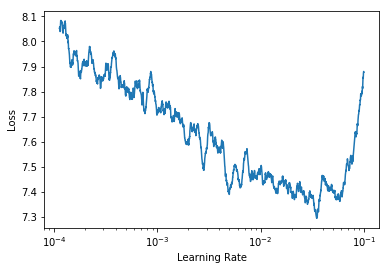

In [83]:
learner.plot_lrs(50)


In [84]:
len(learner.lrs)

2910

In [85]:
len(learner.losses)

2910

In [71]:
learner.run_epochs(train_tokens,valid_tokens,1)

AttributeError: 'language_model' object has no attribute 'model'

In [48]:
bs

20

In [62]:
class RNNModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, rnn_type, ntoken, ninp, nhid, nlayers, dropout=0.5, tie_weights=False):
        super(RNNModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        if rnn_type in ['LSTM', 'GRU']:
            self.rnn = getattr(nn, rnn_type)(ninp, nhid, nlayers, dropout=dropout)
        else:
            try:
                nonlinearity = {'RNN_TANH': 'tanh', 'RNN_RELU': 'relu'}[rnn_type]
            except KeyError:
                raise ValueError( """An invalid option for `--model` was supplied,
                                 options are ['LSTM', 'GRU', 'RNN_TANH' or 'RNN_RELU']""")
            self.rnn = nn.RNN(ninp, nhid, nlayers, nonlinearity=nonlinearity, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

        # Optionally tie weights as in:
        # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
        # https://arxiv.org/abs/1608.05859
        # and
        # "Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling" (Inan et al. 2016)
        # https://arxiv.org/abs/1611.01462
        if tie_weights:
            if nhid != ninp:
                raise ValueError('When using the tied flag, nhid must be equal to emsize')
            self.decoder.weight = self.encoder.weight

        self.init_weights()

        self.rnn_type = rnn_type
        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        if self.rnn_type == 'LSTM':
            return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                    weight.new_zeros(self.nlayers, bsz, self.nhid))
        else:
            return weight.new_zeros(self.nlayers, bsz, self.nhid)

In [65]:
newmodel=torch.load('/home/kirana/Documents/phd/examples/examples/word_language_model/model.pt')

In [66]:
newmodel

RNNModel(
  (drop): Dropout(p=0.2)
  (encoder): Embedding(33278, 200)
  (rnn): LSTM(200, 200, num_layers=2, dropout=0.2)
  (decoder): Linear(in_features=200, out_features=33278, bias=True)
)

In [75]:
newmodel.encoder.weight.data.numpy()

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.